# Local Search post-processing
The goal of this tutorial is to demonstrate how post-processing—specifically, Local Search—can improve the solutions obtained from QAOA, whether run on a noisy quantum device or a noise simulator. We revisit [the multi-car paint shop problem](https://jij-inc.github.io/Qamomile/tutorial/qaoa/multi_car_paint.html) as our target optimization task, this time with a larger number of cars and models. The objective remains to minimize the number of color switches between cars on the paint shop line during the manufacturing process.

In this tutorial, we focus on a simplified scenario with only two colors.

## Expressing the problem using a mathematical model

Given a set of cars $ X = \{x_1, x_2, \dots, x_n\} $ that need to be painted in one of two colors, denoted as $ x_i=0 $ and $ x_i=1 $,  for each $ i = 1, \dots n$. The objective is to minimize the number of color switches (i.e., changes from $ 0 $ to $ 1 $ or from $ 1 $ to $ 0 $) between consecutive cars in the sequence.


The cost of the sequence is the number of times the color switches between consecutive cars, which can be formulated as:

$$
\text{min} \quad - \sum_{i=0}^{N-2} s_i s_{i+1}.
$$

The term, $-s_i \cdot s_{i+1}$, represents consecutive cars and indicates whether they are going to be painted the same color, either $-1$ or $1$. This term becomes $-1$ when the cars are painted the same color, and $+1$ when they are painted different colors. Summing over all the cars in $X$, the cost function is minimized. By converting the spin variables to binary variables, the mathematical expression transforms into the following: 

$$
\text{min} \quad -\sum_{i=0}^{N-2} (x_i - 0.5) \cdot (x_{i+1} - 0.5).
$$

In the Two-Color Multi-Car Paint Shop Problem, the goal is to minimize the number of color switches while meeting specific constraints. In this notebook, we consider the constraint that the scheduled number of cars in each of the two colors per model (the total number of models is $M$) must be met.

$$
 V_{i,m} \cdot x_i = W_m \quad ,\forall m \in \{0, \dots, M-1\}
$$

, where $V_{i,m}$ is a one-hot 2-dimensional matrix representing which model each car $i$ belongs to.

In [2]:
import jijmodeling as jm
import ommx.v1
import qamomile as qm
import numpy as np
import random as rand

## Formulation using JijModeling
Let's first model the problem using `JijModeling`.

In [3]:
def get_mcps_problem() -> jm.Problem:
  V = jm.Placeholder("V", ndim=2) # sequence of car entry
  W = jm.Placeholder("W", ndim=1) # number of black cars by model
  N = jm.Placeholder("N") # number of cars
  M = jm.Placeholder("M") # number of car models
  x = jm.BinaryVar("x", shape=(N,))
  i = jm.Element("i", belong_to=(0, N-1))
  j = jm.Element("j", belong_to=(0, N))
  m = jm.Element("m", belong_to=(0, M))

  problem = jm.Problem("MCPS") 
  problem += jm.sum([i], -(x[i] - 0.5) * (x[i+1] - 0.5))
  problem += jm.Constraint("n-hot", jm.sum([j], V[j][m] * x[j]) == W[m], forall=m)
  return problem
problem = get_mcps_problem()
problem

We specify the number of cars, the number of models, and the total number of cars to be painted. The number of painted cars assigned to each model is randomly determined, with the constraint that each model must have at least one car scheduled for painting.

In [28]:
import numpy as np
import random as rand

number_of_models = 5
number_of_cars = 40
total_black_cars = number_of_models * 1
car_map = {i: f"Model {i}" for i in range(number_of_models)}

# Create car sequence: each model appears at least once
cars = [i for i in range(number_of_models)]  
# Fill the rest of cars randomly
cars += [rand.randint(0, number_of_models - 1) for _ in range(number_of_cars - number_of_models)]
rand.shuffle(cars)
print(f"Order of car intake: {[car_map[car] for car in cars]}")

# One-hot encoding
cars_onehot = np.eye(number_of_models)[cars]
print(f"Car types: {[car_map[i] for i in range(number_of_models)]}")
print(cars_onehot)

# Randomly distribute total_black_cars across models
black_per_models = [1] * number_of_models  #at least one black car per model
for _ in range(total_black_cars-number_of_models):
    idx = rand.randint(0, number_of_models - 1)
    black_per_models[idx] += 1

print(f"Black car count per model: {black_per_models}")


Order of car intake: ['Model 4', 'Model 1', 'Model 1', 'Model 3', 'Model 1', 'Model 1', 'Model 4', 'Model 4', 'Model 2', 'Model 0', 'Model 4', 'Model 2', 'Model 2', 'Model 1', 'Model 1', 'Model 3', 'Model 1', 'Model 0', 'Model 0', 'Model 0', 'Model 4', 'Model 0', 'Model 1', 'Model 0', 'Model 4', 'Model 0', 'Model 0', 'Model 4', 'Model 1', 'Model 4', 'Model 2', 'Model 0', 'Model 3', 'Model 3', 'Model 0', 'Model 2', 'Model 0', 'Model 4', 'Model 0', 'Model 3']
Car types: ['Model 0', 'Model 1', 'Model 2', 'Model 3', 'Model 4']
[[0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]
 [1

## Creating an Instance
An instance is created where actual values are substituted into the constants of the mathematical expressions. Before converting to various algorithms, it is necessary to first create this instance using `JijModeling.Interpreter` and `ommx.Instance`.

In [29]:
data = {"V": cars_onehot, "W":  black_per_models, "N":  number_of_cars, "M": number_of_models}
interpreter = jm.Interpreter(data)
instance = interpreter.eval_problem(problem)

## Generation of QAOA Circuit and Hamiltonian Using Qamomile
`Qamomile` provides a converter that generates circuits and Hamiltonians for QAOA from the compiled instance. Additionally, it allows setting parameters that arise during the conversion to QUBO.

First, we will generate the Ising Hamiltonian. Once this is done, we can also generate the quantum circuit and Hamiltonian for QAOA. 

In [90]:
from qamomile.core.converters.qaoa import QAOAConverter
from qamomile.core.circuit.drawer import plot_quantum_circuit

qaoa_converter = QAOAConverter(instance)
# Encode to Ising Hamiltonian
qaoa_converter.ising_encode(multipliers={"n-hot": 0.5})
# Get the QAOA circuit
p=1
qaoa_circuit = qaoa_converter.get_qaoa_ansatz(p=p)
# plot_quantum_circuit(qaoa_circuit) #print it out
# Get the cost Hamiltonian
qaoa_cost = qaoa_converter.get_cost_hamiltonian()

## Converting the Obtained Circuit and Hamiltonian for Qiskit
let's first convert the circuit and Hamiltonian for Qiskit.

In [91]:
import qamomile.qiskit as qm_qk
qk_transpiler = qm_qk.QiskitTranspiler()

# Transpile the QAOA circuit to Qiskit
qk_circuit = qk_transpiler.transpile_circuit(qaoa_circuit)
qk_hamiltonian = qk_transpiler.transpile_hamiltonian(qaoa_cost)

## Running QAOA
Let’s run QAOA using SciPy’s COBYLA as the classical optimization algorithm. The optimization is performed with [Qiskit’s MPS (Matrix Product State) simulation method](https://qiskit.github.io/qiskit-aer/tutorials/7_matrix_product_state_method.html) and the noiseless AerSimulator. We choose the MPS method over the statevector approach because it can efficiently simulate systems with a large number of qubits. However, simulating large systems without specifying a maximum bond dimension can still be computationally expensive. Therefore, selecting an appropriate bond dimension is crucial to balancing simulation accuracy and runtime efficiency.

In [80]:
from qiskit_aer.primitives import EstimatorV2
from qiskit_ibm_runtime.fake_provider import FakeKyoto
from qiskit_aer import AerSimulator
from qiskit import transpile
from scipy.optimize import minimize

def optimize_circuit(qk_circuit, qk_hamiltonian, shots, noises=False, initial_params=None):
    if noises:
        device_backend = FakeKyoto()
        sim = AerSimulator.from_backend(device_backend, method='matrix_product_state')
    
    else:
        sim = AerSimulator(method='matrix_product_state')

    sim.set_options(matrix_product_state_max_bond_dimension= 16)
    cost_history = []
    coupling_map = FakeKyoto().configuration().coupling_map
    transpiled_circuit = transpile(qk_circuit, backend=sim, optimization_level=3, coupling_map=coupling_map)
    transpiled_hamiltonian = qk_hamiltonian.apply_layout(transpiled_circuit.layout)

    def cost_estimator(param_values, shots=shots):
        estimator = EstimatorV2.from_backend(sim)
        job = estimator.run([(transpiled_circuit, transpiled_hamiltonian, param_values)])
        result = job.result()[0]
        cost = result.data['evs']
        cost_history.append(cost)
        return cost

    result = minimize(cost_estimator, initial_params, method="COBYLA", options={"maxiter": 500})
    return result, cost_history

In [92]:
result, cost_history = optimize_circuit(qk_circuit, qk_hamiltonian, shots=1000 ,noises=False, initial_params=np.random.rand(2*p) * np.pi)
print(result)

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: 23.002405215487506
       x: [ 2.365e+00  2.117e+00]
    nfev: 36
   maxcv: 0.0


Let's also take a look at the changes in the cost function

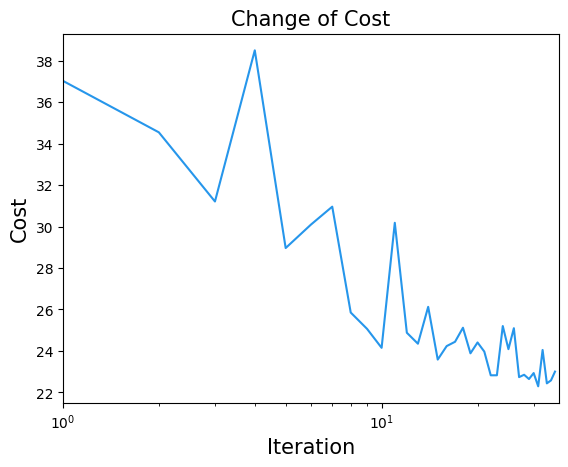

In [95]:
import matplotlib.pyplot as plt

plt.title("Change of Cost", fontsize=15)
plt.xlabel("Iteration", fontsize=15)
plt.ylabel("Cost", fontsize=15)
plt.xscale("log")
plt.xlim(1, result.nfev)
plt.plot(cost_history, label="Cost", color="#2696EB")
plt.show()

After obtaining the QAOA parameters, we perform sampling using the noisy FakeKyoto backend, again with the MPS simulation method.

In [11]:
from qiskit.primitives import BackendSamplerV2

def run_simulation(qk_circuit, params, shots, noises=False):
    if noises:
        device_backend = FakeKyoto()
        sim = AerSimulator.from_backend(device_backend, method='matrix_product_state') 
    
    else:
        sim = AerSimulator(method='matrix_product_state')

    sim.set_options(matrix_product_state_max_bond_dimension= 16)
    sampler = BackendSamplerV2(backend = sim)
    qk_circuit.measure_all()
    coupling_map = FakeKyoto().configuration().coupling_map
    tcirc = transpile(qk_circuit, backend=sim, optimization_level=3 , coupling_map=coupling_map)
    job = sampler.run([(tcirc, params)], shots=shots)
    
    return job.result()[0]

In [93]:
job_result = run_simulation(qk_circuit, result.x, shots=10000, noises= True)


## Evaluating the Results

The optimal painting order and its corresponding transition score can be determined. If a solution is infeasible, its transition score will be set to None.

In [36]:
def eval_mcps_state(cars, black_per_models, state, num_cars, num_models):
    cnt = [0] * num_models
    for i in range(num_cars):
        cnt[cars[i]] += state[i]
    for i in range(num_models):
        if black_per_models[i] != cnt[i]:
            return None
    score = 0
    for i in range(num_cars - 1):
        if state[i] != state[i + 1]:
            score += 1
    return score

In [94]:
paint_map = {
    1: "⚫",  # Black heart 
    0: ""    # Empty string
}

sampleset = qaoa_converter.decode(qk_transpiler, job_result.data["meas"])

try:
    best_sample = sampleset.best_feasible_unrelaxed()
    best_values = best_sample.extract_decision_variables("x")
except:
    print("cannot find a feasible solution")
    objectives = sampleset.objectives
    best_index = min(objectives, key=objectives.get)
    best_values = sampleset.get(sample_id=best_index).extract_decision_variables("x")

solution = np.array([best_values.get((i,)) for i in range(len(cars))])
score = eval_mcps_state(cars, black_per_models, solution, number_of_cars, number_of_models)

print("Minimum transition score:", score)
print("The order of car intake: ", [car_map[car] for car in cars])
print("Color separation: ", [paint_map[value] for value in solution])

cannot find a feasible solution
Minimum transition score: None
The order of car intake:  ['Model 4', 'Model 1', 'Model 1', 'Model 3', 'Model 1', 'Model 1', 'Model 4', 'Model 4', 'Model 2', 'Model 0', 'Model 4', 'Model 2', 'Model 2', 'Model 1', 'Model 1', 'Model 3', 'Model 1', 'Model 0', 'Model 0', 'Model 0', 'Model 4', 'Model 0', 'Model 1', 'Model 0', 'Model 4', 'Model 0', 'Model 0', 'Model 4', 'Model 1', 'Model 4', 'Model 2', 'Model 0', 'Model 3', 'Model 3', 'Model 0', 'Model 2', 'Model 0', 'Model 4', 'Model 0', 'Model 3']
Color separation:  ['', '', '', '', '⚫', '', '', '', '', '', '⚫', '', '', '', '', '', '⚫', '', '', '', '', '', '', '', '', '', '', '⚫', '', '', '', '⚫', '⚫', '⚫', '', '', '', '⚫', '', '']


We examine the distribution of the objective function values.

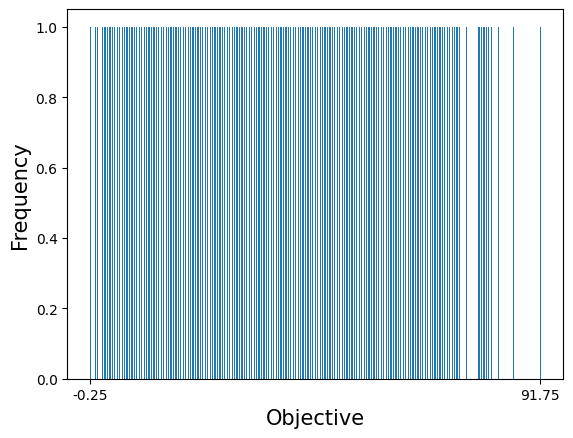

In [96]:
from collections import defaultdict
import matplotlib.pyplot as plt

sampleset = qaoa_converter.decode(qk_transpiler, job_result.data["meas"])

# Initialize a dictionary to accumulate occurrences for each energy value
frequencies = defaultdict(int)

# Define the precision to which you want to round the energy values
energy = []
frequencies = {}
for entry in sampleset.raw.objectives.entries:
    e = round(entry.value, ndigits = 3)
    frequencies[e] = len(entry.ids)


plt.bar(frequencies.keys(), frequencies.values(), width=0.25)
x_vals = sorted(frequencies.keys())
plt.xticks([x_vals[0], x_vals[-1]], labels=[f"{x_vals[0]}", f"{x_vals[-1]}"], rotation=0)
plt.xlabel('Objective', fontsize=15)
plt.ylabel('Frequency', fontsize=15)
plt.show()

## Post process using local serach
First compute the best costs using`OMMXOpenJijSAAdapter`.

In [97]:
from ommx_openjij_adapter import OMMXOpenJijSAAdapter

sample_SA = OMMXOpenJijSAAdapter.sample(instance, num_reads=100, uniform_penalty_weight=1.4)
best_sample_SA = sample_SA.best_feasible_unrelaxed()
best_values_SA = best_sample_SA.extract_decision_variables("x")

solution_SA = np.array([best_values_SA.get((i,)) for i in range(len(cars))])
score_SA = eval_mcps_state(cars, black_per_models, solution_SA, number_of_cars, number_of_models)

print("Minimum transition score:", score_SA)
print("The order of car intake: ", [car_map[car] for car in cars])
print("Color separation: ", [paint_map[value] for value in solution_SA])

Minimum transition score: 2
The order of car intake:  ['Model 4', 'Model 1', 'Model 1', 'Model 3', 'Model 1', 'Model 1', 'Model 4', 'Model 4', 'Model 2', 'Model 0', 'Model 4', 'Model 2', 'Model 2', 'Model 1', 'Model 1', 'Model 3', 'Model 1', 'Model 0', 'Model 0', 'Model 0', 'Model 4', 'Model 0', 'Model 1', 'Model 0', 'Model 4', 'Model 0', 'Model 0', 'Model 4', 'Model 1', 'Model 4', 'Model 2', 'Model 0', 'Model 3', 'Model 3', 'Model 0', 'Model 2', 'Model 0', 'Model 4', 'Model 0', 'Model 3']
Color separation:  ['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '⚫', '⚫', '⚫', '⚫', '⚫', '', '', '', '', '', '', '']


Using `LocalSearch` can help improve the quality of solutions. Choosing an appropriate value for the multipliers is crucial—if the value is too small, the algorithm may fail to find a feasible solution; if it’s too large, it may not enhance the existing one.

`_run_local_search` contains two type of local search namely `best_improvement` and `first_improvement`. `best_improvement` examines all possible single-bit flips in the current state of the Ising model to identify the one that yields the greatest reduction in energy. In contrast, `first_improvement` iteratively checks each bit in the current state and flips the first one it finds that leads to a decrease in energy, without evaluating all possibilities. The `max_iter` determines the maximum number of iterations for the local search.

In [98]:
from qamomile.core.post_process.local_search import LocalSearch

spin_state = 1 - 2 * solution
local_search_instance=LocalSearch(qaoa_converter) #make a local search instance
new_spin_state = local_search_instance._run_local_search(
        method=local_search_instance.best_improvement, initial_state=spin_state, max_iter=-1
    )
new_solution=(1 - new_spin_state) // 2


In [99]:
local_score = eval_mcps_state(cars, black_per_models, new_solution, number_of_cars, number_of_models)
print("solution after local search: ", local_score)
print("The order of car intake: ", [car_map[car] for car in cars])
print("Color separation: ", [paint_map[value] for value in new_solution])

solution after local search:  2
The order of car intake:  ['Model 4', 'Model 1', 'Model 1', 'Model 3', 'Model 1', 'Model 1', 'Model 4', 'Model 4', 'Model 2', 'Model 0', 'Model 4', 'Model 2', 'Model 2', 'Model 1', 'Model 1', 'Model 3', 'Model 1', 'Model 0', 'Model 0', 'Model 0', 'Model 4', 'Model 0', 'Model 1', 'Model 0', 'Model 4', 'Model 0', 'Model 0', 'Model 4', 'Model 1', 'Model 4', 'Model 2', 'Model 0', 'Model 3', 'Model 3', 'Model 0', 'Model 2', 'Model 0', 'Model 4', 'Model 0', 'Model 3']
Color separation:  ['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '⚫', '⚫', '⚫', '⚫', '⚫', '', '', '', '', '', '', '']
